## 1. Make classification data and get it ready

In [167]:
import matplotlib.pyplot as plt

SEED = 42
from sklearn.datasets import make_circles

In [168]:
# Make 1000 samples
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=SEED)

len(X), len(y)

(1000, 1000)

In [169]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [170]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [171]:
import plotly.express as px


def plot_3d(df, feature1, feature2, label):
    """
    Biểu diễn dữ liệu 3D với 2 đặc trưng và 1 nhãn.

    Args:
    df (pd.DataFrame): DataFrame chứa dữ liệu.
    feature1 (str): Tên cột của đặc trưng thứ nhất.
    feature2 (str): Tên cột của đặc trưng thứ hai.
    label (str): Tên cột của nhãn.

    Returns:
    None
    """
    fig = px.scatter_3d(df, x=feature1, y=feature2, z=label, color=label)
    fig.show()


plot_3d(circles, "X1", "X2", "label")

***Note**: the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamental*

## 1.1 Check input and output shapes

In [172]:
X.shape, y.shape

((1000, 2), (1000,))

In [173]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
shape for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [174]:
import torch as t

t.__version__

'2.1.2+cpu'

In [175]:
# turn data into tensor
X = t.from_numpy(X).type(t.float32)
y = t.from_numpy(y).type(t.float32)

In [176]:
# split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model
classify dot of 0 or 1

**step:**
1. Setup device agonistic code
2. construct a model
3. define a loss and optimizer
4. create a training and test loop

In [177]:
from torch import nn

device = "cuda" if t.cuda.is_available() else 'cpu'
device

'cpu'

In [178]:
# construct model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(
            in_features=2,  # take in 2 feats
            out_features=5  # upscale into 5 feats
        )
        self.layer2 = nn.Linear(
            in_features=5,  # take in the num of feats is the previous out feats
            out_features=1  # same shape as y
        )

    def forward(self, x):
        return self.layer2(self.layer1(x))  # x -> layer1 -> layer2 -> output


t.manual_seed(SEED)
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [179]:
## let's replicate the model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [180]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [181]:
# make predictions
with t.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)} | shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)} | Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200 | shape: torch.Size([200, 1])
Length of test samples: 200 | Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 setup loss fn and optimizer
1. *Loss:*
* Regression
    * MAE
    * MSE
* Classification
    * BinaryCrossEntropy 
    * CategoricalCrossEntropy (CrossEntropy)
2. *Optimizer:*
* SGD
* Adam

In [182]:
# loss_fn = nn.BCELoss() # BCELoss = require inputs to have gone through the sigmoid activation function prior to input to BCELoss: Sigmoid -> BCE
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in
optimizer = t.optim.SGD(params=model_0.parameters(),lr=0.1)

In [183]:
from metrics import accuracy

## 3. train model
1. Forward pass
2. Loss
3. Optimizer zero grad
4. Loss backward (back propagation)
5. optimizer step (gradient decent)

### 3.1 Going from law logits -> prediction probabilities -> prediction labels
our model outputs are going to be raw **logits**
we can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification)

Then we can convert model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`

In [184]:
# view first 5 outputs of the forward pass on the test data
with t.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [185]:
# use the sigmoid activation function in our model to turn them into prediction probability
y_pred_probs = t.sigmoid(y_logits)
t.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)


In [186]:
# find the predicted labels
y_preds = t.round(y_pred_probs)

# in full (logits -> pred probs -> pred labels)
y_pred_labels = t.round(t.sigmoid(model_0(X_test.to(device))[:5]))

print(t.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

## 3.2 Building training and testing loop

In [187]:
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)

epochs = 100

# put data into target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# check log 
epoch_count = []
loss_values = []
test_loss_value = []
accs = []
test_accs = []

# training loop
for epoch in range(epochs):
    model_0.train()
    
    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = t.round(t.sigmoid(y_logits)) # logits -> pred prob -> pred label
    
    # 2. loss/metrics
    # loss = loss_fn(t.sigmoid(y_logits),y_train) # BCELoss expect prediction probs as input
    loss = loss_fn(y_logits, y_train) # BCEwithlogitsloss expect raw logits as input
    acc = accuracy(y_true=y_train, y_pred= y_pred)
    
    # 3. optimizer zero grad
    optimizer.zero_grad()
    
    # 4. backward
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with t.inference_mode():
        # 1. forward
        test_logits = model_0(X_test).squeeze()
        test_pred = t.round(t.sigmoid(test_logits))
        
        # 2. calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)
        
        # 3. print
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f} ")
            
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_value.append(test_loss)
            accs.append(acc)
            test_accs.append(test_acc)
            
            

Epoch: 0 | Loss: 0.69796, Acc: 51.88 | Test loss: 0.69440, Test acc: 58.00 
Epoch: 10 | Loss: 0.69590, Acc: 51.25 | Test loss: 0.69305, Test acc: 53.00 
Epoch: 20 | Loss: 0.69490, Acc: 51.62 | Test loss: 0.69254, Test acc: 49.50 
Epoch: 30 | Loss: 0.69435, Acc: 51.12 | Test loss: 0.69236, Test acc: 49.50 
Epoch: 40 | Loss: 0.69401, Acc: 50.88 | Test loss: 0.69232, Test acc: 51.00 
Epoch: 50 | Loss: 0.69378, Acc: 50.25 | Test loss: 0.69234, Test acc: 50.00 
Epoch: 60 | Loss: 0.69362, Acc: 50.00 | Test loss: 0.69239, Test acc: 51.50 
Epoch: 70 | Loss: 0.69351, Acc: 50.25 | Test loss: 0.69246, Test acc: 51.00 
Epoch: 80 | Loss: 0.69342, Acc: 49.88 | Test loss: 0.69254, Test acc: 50.00 
Epoch: 90 | Loss: 0.69336, Acc: 49.88 | Test loss: 0.69262, Test acc: 53.00 


## 4. Make predictions and evaluate the model

look like out model isn't learn anything

In [188]:
import requests
from pathlib import Path

# download helper function from learn pytorch repo
if Path("helper_function.py").is_file():
    print("helper_function.py already exist, skipping download")
else:
    print("Download helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_function.py','wb') as f:
        f.write(request.content)
        print("downloaded successful")

helper_function.py already exist, skipping download


In [192]:
from helper_function import plot_decision_boundary

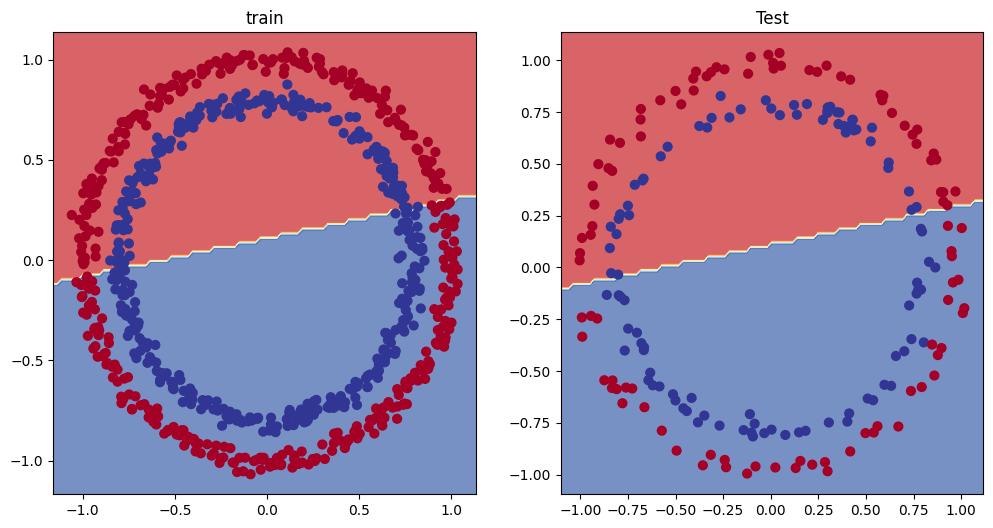

In [193]:
import matplotlib.pyplot as plt
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)